In [ ]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=ad142d903d18e418ea7821abd3c132cff47cdd6418ee2825bd5760fb92145be6
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


Initializing model and tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Using device: cuda
Starting training...

Epoch 1/3


Evaluating: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Train Loss: 1.7184, Train ROUGE-L: 0.2210
Val Loss: 0.9055, Val ROUGE-L: 0.2532
Saved best model with ROUGE-L: 0.2532

Epoch 2/3


Evaluating: 100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Train Loss: 0.8623, Train ROUGE-L: 0.2904
Val Loss: 0.8732, Val ROUGE-L: 0.2705
Saved best model with ROUGE-L: 0.2705

Epoch 3/3


Evaluating: 100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


Train Loss: 0.8278, Train ROUGE-L: 0.3012
Val Loss: 0.8705, Val ROUGE-L: 0.2695

Final Results:
   epoch  train_loss  train_rouge  val_loss  val_rouge
0      1    1.718436     0.220992  0.905466   0.253182
1      2    0.862337     0.290354  0.873165   0.270498
2      3    0.827761     0.301215  0.870526   0.269514


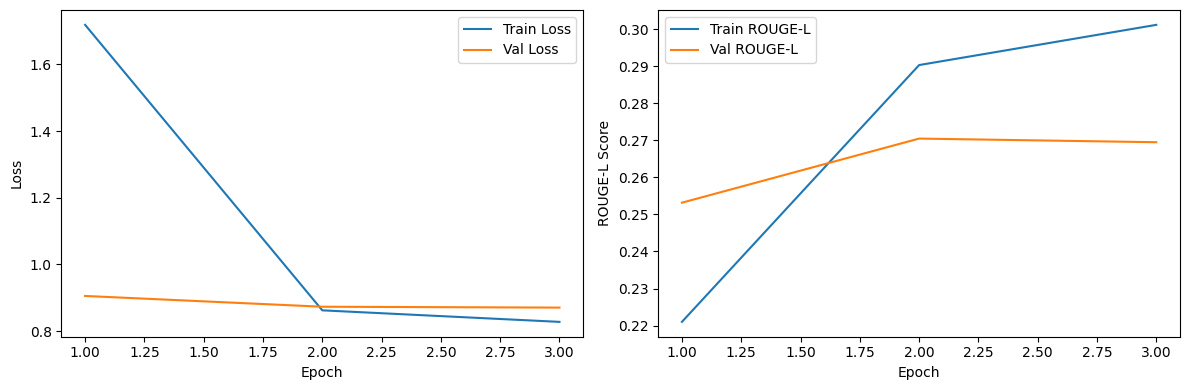

Generating predictions for test data...


Generating Test Predictions: 100%|██████████| 450/450 [01:32<00:00,  4.86it/s]

Predictions saved to test_predictions.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from rouge_score import rouge_scorer
import math

# Load datasets
train_path = '/content/LABELLED_TRAIN.csv'
dev_path = '/content/LABELLED_DEV.csv'
test_path = '/content/UNLABELLED_TEST.csv'

# Load datasets into pandas DataFrames
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

class HeadlineDataset(Dataset):
    def __init__(self, articles, headlines, tokenizer, max_len=512):
        self.articles = articles
        self.headlines = headlines
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        article = "summarize: " + self.articles[idx]
        headline = self.headlines[idx]

        inputs = self.tokenizer.encode_plus(
            article,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        targets = self.tokenizer.encode_plus(
            headline,
            max_length=50,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': targets['input_ids'].squeeze(0),
            'raw_headline': headline  # Added for ROUGE calculation
        }

def calculate_rouge_batch(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = []
    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)
        scores.append(score['rougeL'].fmeasure)
    return np.mean(scores)

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_rouge_scores = []

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        raw_headlines = batch['raw_headline']

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        # Generate headlines for ROUGE calculation
        with torch.no_grad():
            generated = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=50,
                num_beams=5,
                early_stopping=True
            )

            predictions = tokenizer.batch_decode(generated, skip_special_tokens=True)
            rouge_score = calculate_rouge_batch(predictions, raw_headlines)
            all_rouge_scores.append(rouge_score)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'rouge-l': f'{rouge_score:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })

    return total_loss / len(dataloader), np.mean(all_rouge_scores)

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_rouge_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            raw_headlines = batch['raw_headline']

            # Calculate loss
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            total_loss += outputs.loss.item()

            # Generate headlines for ROUGE calculation
            generated = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=50,
                num_beams=5,
                early_stopping=True
            )

            predictions = tokenizer.batch_decode(generated, skip_special_tokens=True)
            rouge_score = calculate_rouge_batch(predictions, raw_headlines)
            all_rouge_scores.append(rouge_score)

    return total_loss / len(dataloader), np.mean(all_rouge_scores)

def generate_test_predictions(model, test_df, tokenizer, device):
    model.eval()
    test_articles = test_df['News Article'].tolist()
    predictions = []

    with torch.no_grad():
        for article in tqdm(test_articles, desc="Generating Test Predictions"):
            inputs = tokenizer(
                "summarize: " + article,
                max_length=512,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            generated = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=50,
                num_beams=5,
                early_stopping=True
            )

            prediction = tokenizer.decode(generated[0], skip_special_tokens=True)
            predictions.append(prediction)

    test_df['Prediction'] = predictions
    test_df[['ID', 'Prediction']].to_csv('test_predictions.csv', index=False)
    print("Predictions saved to test_predictions.csv")

# Main training setup
print("Initializing model and tokenizer...")
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Prepare data
X_train = train_df['News Article'].tolist()
y_train = train_df['Caption'].tolist()
X_dev = dev_df['News Article'].tolist()
y_dev = dev_df['Caption'].tolist()

# Create datasets and dataloaders
train_dataset = HeadlineDataset(X_train, y_train, tokenizer)
dev_dataset = HeadlineDataset(X_dev, y_dev, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-6)

# Training loop with ROUGE-L tracking
best_rouge_l = 0
results = []

print("Starting training...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    train_loss, train_rouge = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_rouge = evaluate(model, dev_loader, device)

    print(f"Train Loss: {train_loss:.4f}, Train ROUGE-L: {train_rouge:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val ROUGE-L: {val_rouge:.4f}")

    results.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_rouge': train_rouge,
        'val_loss': val_loss,
        'val_rouge': val_rouge
    })

    # Save best model based on ROUGE-L score
    if val_rouge > best_rouge_l:
        best_rouge_l = val_rouge
        model.save_pretrained("best_headline_model")
        tokenizer.save_pretrained("best_headline_model")
        print(f"Saved best model with ROUGE-L: {val_rouge:.4f}")

# Print final results
print("\nFinal Results:")
results_df = pd.DataFrame(results)
print(results_df)

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
plt.plot(results_df['epoch'], results_df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results_df['epoch'], results_df['train_rouge'], label='Train ROUGE-L')
plt.plot(results_df['epoch'], results_df['val_rouge'], label='Val ROUGE-L')
plt.xlabel('Epoch')
plt.ylabel('ROUGE-L Score')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions for test data
print("Generating predictions for test data...")
generate_test_predictions(model, test_df, tokenizer, device)
